In [2]:
import torch
import torchvision.models as models
import cv2
import numpy as np
import os
import glob
import time
from keras.preprocessing import image
import skimage.feature as sf

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution3D, MaxPooling3D
import keras.optimizers as opt
from keras.utils import np_utils, generic_utils
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection  import train_test_split

from sklearn import preprocessing
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
def getImageList(imageDirectory):
  rImages = glob.glob(imageDirectory + "/*.jpg")
  rImages +=  glob.glob(imageDirectory + "/*.jpeg")
  rImages +=  glob.glob(imageDirectory + "/*.png")
  return rImages

def load_data(num_frames, factor):
  
  parent_dir  = "/content/drive/Shareddrives/Projects/Fall 2020 Projects/CV/Final Report/UCF_video"
  parent_dir = os.path.abspath(parent_dir)
  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']

  frames_list = []
  labels = []
  Xtr = []
  frame_count = 0

  for act_class in act_classes:
    class_dir = os.path.join(parent_dir, act_class)
    
    for video in os.listdir(class_dir):

      video_dir=os.path.join(class_dir,video)
      print ("IN: ", os.path.join(act_class,video))
      all_frames = getImageList(video_dir)
      all_frames=sorted(all_frames)
      frames_list=[]
      k=0

      if act_class == 'Diving-Side' or act_class== 'Swing':
        nextframe=2*factor
      elif act_class == 'Lifting':
        nextframe=5*factor
      elif act_class =='Kicking':
        nextframe=1*factor
      else:
        nextframe=3*factor

      frame = cv2.imread(all_frames[k])
      frame_count = 1
      while frame_count<=num_frames:
        norm = cv2.normalize(frame, None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        resized = cv2.resize(norm, (64,64), interpolation = cv2.INTER_AREA)
        resized=np.array(resized)
        x=resized.reshape((1,3,64,64))
        frames_list.append(x)

        k+=nextframe
        frame_count += 1
        if frame_count <= num_frames:
          frame = cv2.imread(all_frames[k])      
        
      Xtr.append(frames_list)
      labels.append(act_class)
  return Xtr,labels

In [4]:
def feature_extractor():
  model = models.mobilenet_v2(pretrained=True)
  new_base =  (list(model.children())[:-1])[0]
  return new_base

def extract_features(Xtr,new_base):
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)
      output= new_base[:3](x)
      j=output
  return Xtr

In [5]:

def vgg16(Xtr):
  vgg16 = models.vgg16(pretrained=True)
  for i in Xtr:
    for j in i:
      x=torch.Tensor(j)  
      output = vgg16.features[:3](x)
      j=output
  return Xtr

In [6]:
def hog_feat(frames):
  features = []
  hogX=[]
  for i in frames:
    for j in i:
      newj=j.reshape(64,64,3)
      fd, hog_image=(hog(newj,visualize=True, multichannel=True))
      hog_image=hog_image.reshape(1,64,64)
      features.append(hog_image)
    hogX.append(features)
    features=[]
  return hogX

In [7]:
def NoCNNpreprocess(X,chanel,frames):
  X=np.array(X)
  X=X.reshape(len(X),64*64*chanel*frames)
  print(X.shape)
  return X

In [8]:
def rforest_model():
  clf = RandomForestClassifier(n_estimators=100, random_state=0)
  return clf

In [9]:
def preprocess(labels,Xtr, nb_classes, num_vid, num_frames, channel):

  y=np.zeros(len(labels))
  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']
  for i in range (0, len(y)):
    if labels[i] in act_classes:
      y[i]=act_classes.index(labels[i])
  
  # convert class vectors to binary class matrices
  Y_train = np_utils.to_categorical(y, nb_classes)
  
  Xtr_new=np.array(len(Xtr))
  Xtr_new=np.array(Xtr)
  print("Current shape:", Xtr_new.shape)
  Xtr_new=Xtr_new.reshape(num_vid,channel,num_frames,64,64)
  print("New shape:", Xtr_new.shape)
  return Xtr_new,Y_train

In [10]:
# Define model
def kerasmod3(channel):

  model = Sequential()
  model.add(BatchNormalization())

  model.add(Convolution3D(8, 5, input_shape=(channel,20,64,64), activation='relu', data_format = 'channels_first'))
  model.add(Convolution3D(16, 3, activation='relu'))
  model.add(Convolution3D(32, 3, activation='relu'))

  model.add(Dropout(0.1))
  model.add(MaxPooling3D(pool_size=2))
  

  model.add(Dropout(0.1))

  model.add(Flatten())
  
  model.add(Dropout(0.1))

  model.add(Dense(128, kernel_initializer='normal', activation='relu'))

  model.add(Dense(9, kernel_initializer='normal'))

  model.add(Activation('softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['categorical_accuracy'])

  return model

In [11]:
def main(feat,classmodel):

  act_classes = ['Diving-Side', 'Golf-Swing', 'Kicking', 'Lifting', 'Riding-Horse', 
                 'Run-Side', 'SkateBoarding-Front', 'Swing', 'Walk-Front']
  num_frames=20
  if classmodel=="rf":
    num_frames=10
  factor=1
  channel=3
  nb_classes =9
  #loading and preprocessing
  X,labels=load_data(num_frames,factor)
  start=time.time()

  if feat=='MNet':
    new_base=feature_extractor()
    Xtr=extract_features(X,new_base)

  elif feat=='hog':
    Xtr=hog_feat(X)
    channel =1
  elif feat == 'vgg':
    Xtr=vgg16(X)


  Xtr_new, Y_train=preprocess(labels,Xtr,nb_classes,150,num_frames,channel)  

  # Train the model
  if classmodel=="CNN":
    # CNN Training parameters
    X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,Y_train, 
                                                                      test_size=0.15, random_state=19)
    # Train the model
    model=kerasmod3(channel)
    hist = model.fit(X_train_new, y_train_new, batch_size=  32, epochs = 30,shuffle=True) 
    #for loading already trained model please comment two lines of code above and uncomment the below 2 lines 
    #from keras.models import load_model
    #model= load_model('ucfmodel 73.91.h5')
    
    # Evaluate the model
    score = model.evaluate(X_val_new, y_val_new, batch_size=32)
    print('Test score:', score[0])
    print('Test accuracy:', score[1]) 
    model.save("ucfmodel.h5")
    y_val_new1 = [np.argmax(y, axis=None, out=None) for y in y_val_new]
    y_pred=model.predict_classes(X_val_new)
  
    con_mat = tf.math.confusion_matrix(labels=y_val_new1, predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
    print(con_mat_df)
    print(classification_report(y_val_new1,y_pred))

  else:
    X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(Xtr_new,labels, 
                                                                      test_size=0.15, random_state=19)
    train=NoCNNpreprocess(X_train_new,channel,num_frames)
    test=NoCNNpreprocess(X_val_new,channel,num_frames)
    
    model=rforest_model()

    hist = model.fit(train, y_train_new)#, batch_size=32, epochs=20, shuffle=True)
    # Evaluate the model
    y_pred = model.predict(test)
    accu = model.score(test, y_val_new)
    print("\t   Accuracy    : ", accu)
 
    print(classification_report(y_val_new,y_pred))
  
    con_mat = confusion_matrix(y_val_new, y_pred)
    
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,  index = act_classes,  columns = act_classes)
    print(con_mat_df)
    print(classification_report(y_val_new,y_pred))
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()  
  end=time.time()
  print("Runtime: ", end-start)

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


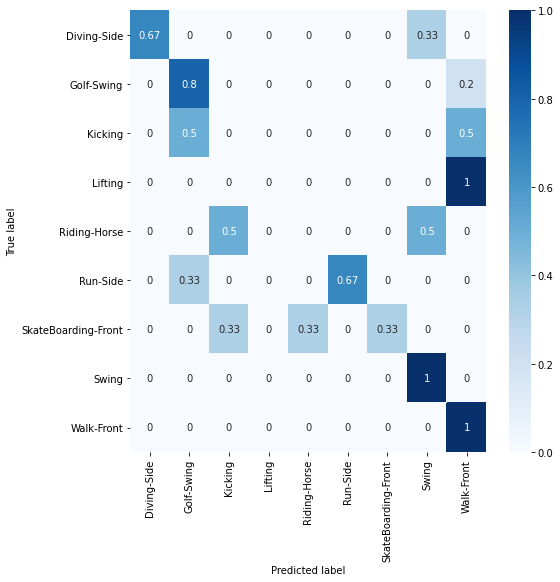

Runtime:  43.38845133781433


In [ ]:
if __name__ == "__main__":
    main('hog','CNN')

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


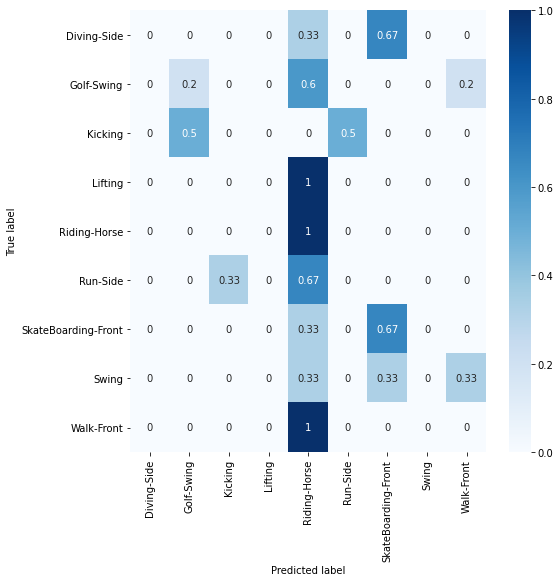

Runtime:  23.51539945602417


In [13]:
if __name__ == "__main__":
    main('MNet','CNN')

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


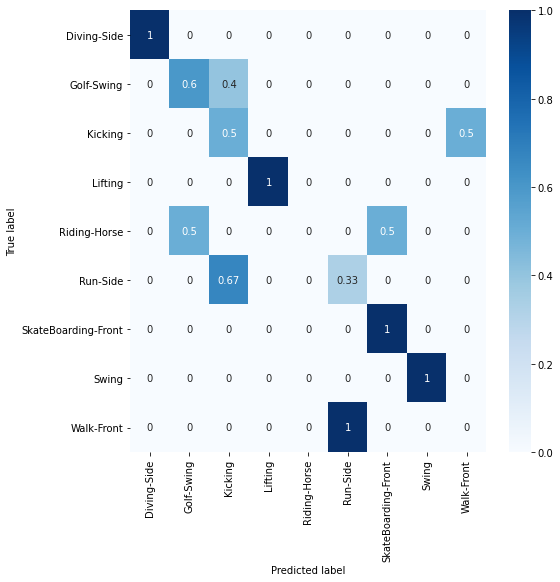

Runtime:  29.937573432922363


In [ ]:
  if __name__ == "__main__":
    main('vgg','CNN')

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


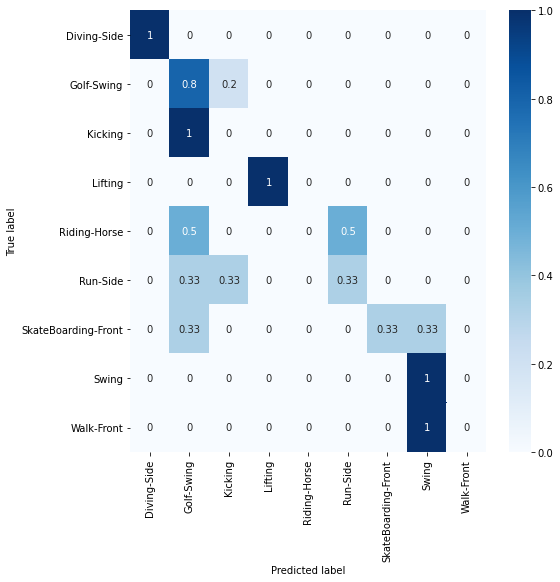

Runtime:  19.14855647087097


In [ ]:
if __name__ == "__main__":
    main('hog','rf')

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


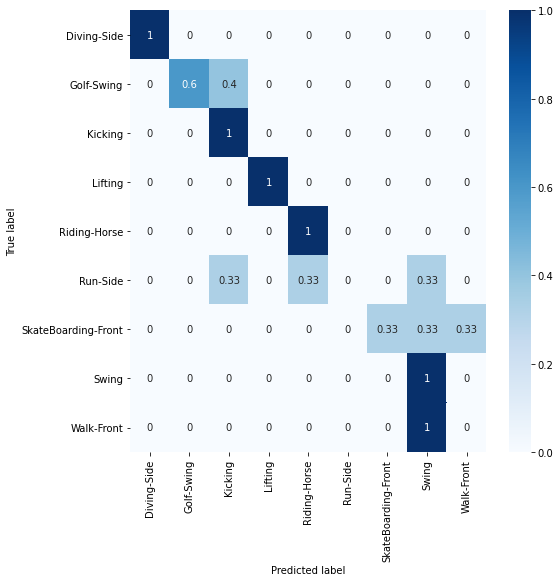

Runtime:  9.190170764923096


In [ ]:
if __name__ == "__main__":
    main('MNet','rf')

IN:  Diving-Side/007
IN:  Diving-Side/006
IN:  Diving-Side/003
IN:  Diving-Side/009
IN:  Diving-Side/008
IN:  Diving-Side/001
IN:  Diving-Side/002
IN:  Diving-Side/004
IN:  Diving-Side/010
IN:  Diving-Side/005
IN:  Diving-Side/011
IN:  Diving-Side/014
IN:  Diving-Side/013
IN:  Diving-Side/012
IN:  Golf-Swing/002
IN:  Golf-Swing/001
IN:  Golf-Swing/004
IN:  Golf-Swing/003
IN:  Golf-Swing/010
IN:  Golf-Swing/007
IN:  Golf-Swing/009
IN:  Golf-Swing/008
IN:  Golf-Swing/005
IN:  Golf-Swing/006
IN:  Golf-Swing/012
IN:  Golf-Swing/011
IN:  Golf-Swing/014
IN:  Golf-Swing/013
IN:  Golf-Swing/015
IN:  Golf-Swing/016
IN:  Golf-Swing/017
IN:  Golf-Swing/018
IN:  Kicking/001
IN:  Kicking/002
IN:  Kicking/004
IN:  Kicking/003
IN:  Kicking/005
IN:  Kicking/006
IN:  Kicking/007
IN:  Kicking/008
IN:  Kicking/012
IN:  Kicking/013
IN:  Kicking/014
IN:  Kicking/011
IN:  Kicking/009
IN:  Kicking/010
IN:  Kicking/016
IN:  Kicking/015
IN:  Kicking/017
IN:  Kicking/018
IN:  Kicking/020
IN:  Kicking/019
IN:  L

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Current shape: (150, 10, 1, 3, 64, 64)
New shape: (150, 3, 10, 64, 64)
(127, 122880)
(23, 122880)
	   Accuracy    :  0.6521739130434783
                     precision    recall  f1-score   support

        Diving-Side       1.00      1.00      1.00         3
         Golf-Swing       1.00      0.60      0.75         5
            Kicking       0.40      1.00      0.57         2
            Lifting       1.00      1.00      1.00         1
       Riding-Horse       0.67      1.00      0.80         2
           Run-Side       0.00      0.00      0.00         3
SkateBoarding-Front       1.00      0.33      0.50         3
              Swing       0.50      1.00      0.67         3
         Walk-Front       0.00      0.00      0.00         1

           accuracy                           0.65        23
          macro avg       0.62      0.66      0.59        23
       weighted avg       0.68      0.65      0.61        23

                     Diving-Side  Golf-Swing  ...  Swing  Walk-Fron

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


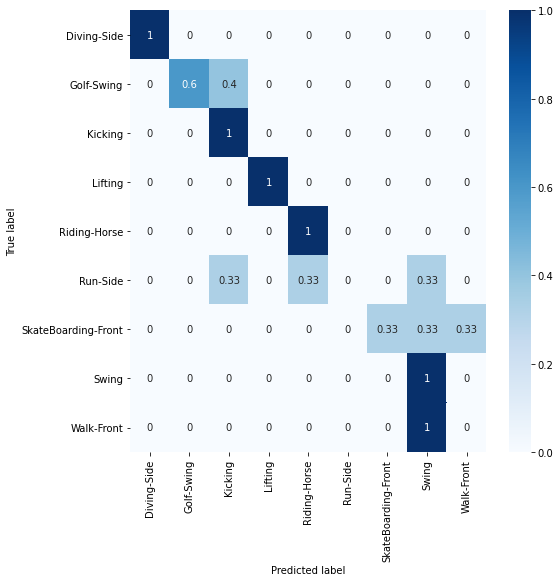

Runtime:  26.734232425689697


In [ ]:
if __name__ == "__main__":
    main('vgg','rf')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive
